### Regression Exercise 
# Moneyball The NBA
---

# Rough Guide a v1 model.
0. Make a model to predict PTS 
0. For v1, dont use `2P, 3P, FG, or FT`.  Instead use `2PA, 3PA, FTA`.  
0. Include any other cols use see fit.  


In [142]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot

import CTPLIB as ctp

In [143]:
df = pd.read_csv('data/NBA_train.csv')
df.dropna(inplace=True)

<Axes: xlabel='W', ylabel='Playoffs'>

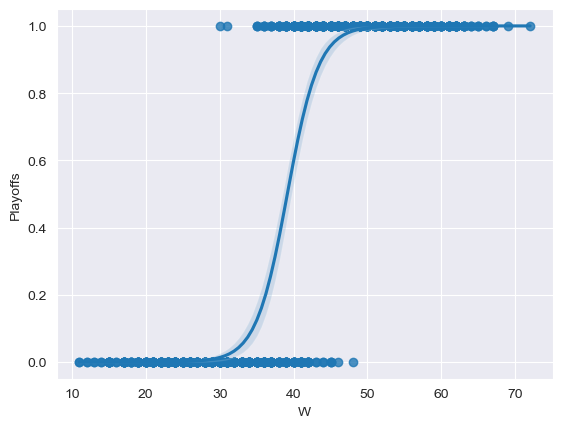

In [144]:
sns.regplot(data=df, x='W', y='Playoffs', logistic=True)

Let Y represent the event of a team making the playoffs. The expression P(Y | W) represents the likelihood a team making the playoffs given W wins.

The bottom and top horizontal lines represent:
- Teams that did not make the playoffs P(Y | W) = 0
- Teams that did make the playoffs P(Y | W) = 1

The logistic regression curve shows that the playoff probability increases exponentially at P(Y | W >= 30) and reaches near certainty at P(Y | W >= 50).
___

To model P(Y | W) we first need to predict the number of Wins. Let's start by filtering out noisy columns (ie. dates and team names) that do not contribute to teams winning.

Additionally, target columns (ie. points, playoffs) must be filtered out, as they indicate a team's performance rather than the underlying factors that drive it.

Text(0.5, 1.0, 'Correlation matrix')

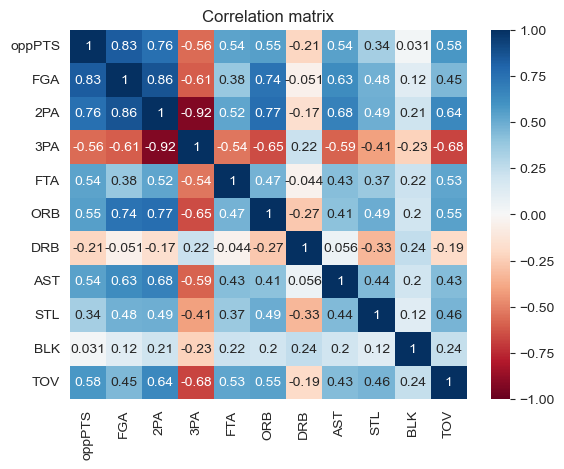

In [145]:
y = df['W'] # target variable, we want to predict Wins
columns_to_drop = ['PTS', '2P', '3P', 'FG', 'FT', 'SeasonEnd', 'Team', 'Playoffs', 'W']
X = df.drop(columns=columns_to_drop)

correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, cmap='RdBu', vmin=-1, vmax=1, annot=True)
plt.title('Correlation matrix')

Column definitions:

- oppPTS: Opponent points (points allowed by the team)
- FGA, 2PA, 3PA, FTA: Field goals attempted, two-point attempts, three-point attempts, free throw attempts
- ORB, DRB: Offensive rebounds, Defensive rebounds
- AST, STL, BLK, TOV: Assists, Steals, Blocks, Turnovers

Multicollinearity, or multiple independent variables being highly related is bad for regression analysis. This is because each additional variable reduces the degrees of freedom regression analysis has, which leads to overfitting. Degrees of freedom (df) is calculated by:

df = n - k - 1, where n = |observations|, let k = |independent variables|

From the correlation matrix, we can see that a number of variables are closely related. Namely:
- FGA and 2PA: Both measure field goals attempted. We'll drop 2PA as FGA is a more generalized.
- FGA and ORB: Correlated, but measure different things. We'll decide after further testing.
---

Next up, we will seek to further reduce independent variables by filtering out variables with low standard deviation. If they do not vary much, it's likely they only serve to reduce the degrees of freedom as opposed to contributing predictive power.

Text(0.5, 1.0, 'Standard deviation of each feature')

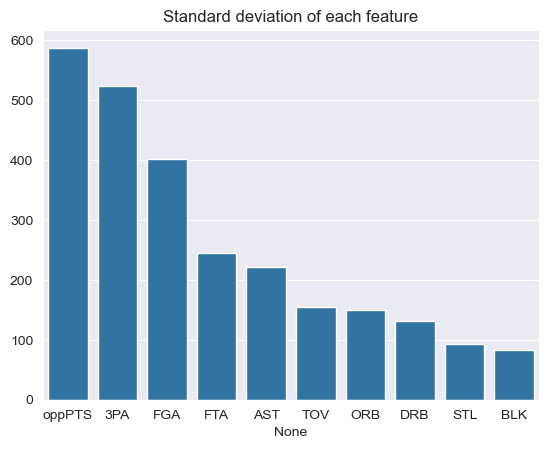

In [146]:
columns_to_drop = ['2PA']
X.drop(columns=columns_to_drop, inplace=True)

sd = X.std()
sd = sd.sort_values(ascending=False)
sns.barplot(x=sd.index, y=sd.values)
plt.title('Standard deviation of each feature')

In [147]:
columns_to_drop = ['STL', 'BLK']
X.drop(columns=columns_to_drop, inplace=True)

By now we have streamlined the dataset by dropping less informative columns, thereby increasing our degrees of freedom. In future projects, it would likely be better to use more quantifiable methods for this process, as opposed to eyeballing it, but I digress.

In [149]:
display(X)

,oppPTS,FGA,3PA,FTA,ORB,DRB,AST,TOV
0,8334,7027,75,2645,1369,2406,1913,1495
1,8664,7387,422,2449,1227,2457,2198,1539
2,9035,6943,275,2592,1115,2465,2152,1684
3,9332,8041,187,2205,1307,2381,2108,1370
4,9240,7470,255,2539,1311,2524,2079,1533
...,...,...,...,...,...,...,...,...
830,8589,6979,1277,1981,1071,2526,1675,1324
831,8034,6628,1727,1984,829,2603,1836,1101
832,8639,6755,1091,1976,963,2343,1795,1206
833,8303,6590,1256,2061,898,2338,1921,1175
